<h1>Obtener los datos de una semana un una ciudad</h1> 

In [25]:
using HTTP
using JSON

location = "Caracas"

start_date = "2024-06-05"  
end_date = "2024-06-11" 

url = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?q=$(location)&tp=24&date=$(start_date)&enddate=$(end_date)&format=json&key=790e4819ffc841c5b1810355241106"

response = HTTP.request("GET", url)

if response.status == 200
    data = JSON.parse(String(response.body))
    println("Datos de la semana del $start_date al $end_date de $location obtenidos correctamente")
else
    println("Error al obtener datos de la semana del $start_date al $end_date: $(response.status)")
end

temperaturas = []

for day in data["data"]["weather"]
    
    avg_temp = day["avgtempC"]
    push!(temperaturas, parse(Int64,avg_temp))
        
end

println(temperaturas)

Datos de la semana del 2024-06-05 al 2024-06-11 de Caracas obtenidos correctamente
Any[23, 23, 22, 22, 20, 22, 21]


<h2>Interpolación de Taylor</h2>

La predicción sobre el punto x0 es: 23.0312500000000 


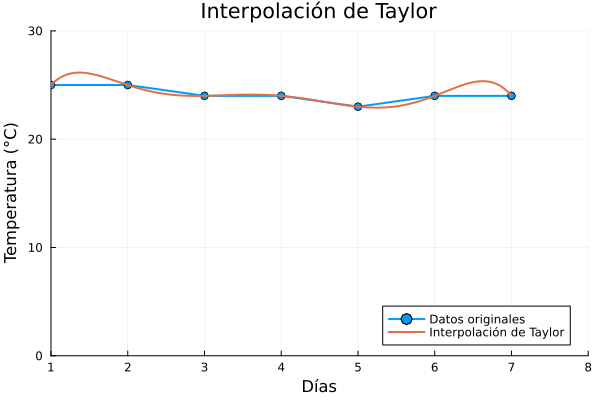

In [7]:
using Plots


#Declaramos el vector para guardar las temperaturas medias de cada dia
temp_medias = temperaturas
dias=1:length(temp_medias)

function Interpolacion_y_prediccion(temp_medias, dias,x0)
    # Variables simbólicas
    x = symbols("x")
    n = length(dias)
    
    # Diferencias finitas
    diferencias = [temp_medias]
    for i in 1:(n-1)
        push!(diferencias, diff(diferencias[end]))
    end
 
    # Construcción del polinomio de Taylor
    polinomio_de_Taylor = diferencias[1][1]
    factorial = 1
    for i in 1:(n-1)
        factorial *= i
        term = diferencias[i+1][1] / factorial
        for j in 0:(i-1)
            term *= (x - dias[j+1])
        end
        polinomio_de_Taylor += term
    end
    
    # Predicción en x0 que tomamos como 2.4
    prediccion = subs(polinomio_de_Taylor, x, x0)
    
    return polinomio_de_Taylor, prediccion,x0
end


# Calcular la interpolación de Taylor y predecir sobre x0
taylor, prediccion, x0 = Interpolacion_y_prediccion(temp_medias, dias,5.5)

#Imprimimos nuestra prediccion
println("La predicción sobre el punto x0 es: $prediccion ")


# Graficamos la funcion de temperaturas por los dias y el polinomio de taylor
plot(dias, temp_medias, label="Datos originales", lw=2, marker=:o)
plot!(taylor, label="Interpolación de Taylor", lw=2)
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación de Taylor")
ylims!(0, 30)
xlims!(1, 8)

<h2>Interpolación de Lagrange</h2>
<br>
$$P(x) = \sum_{i=1}^n y_i L_i(x)$$<br>
$$P(x) = \sum_{i=1}^n y_i \prod_{j=1, j\neq i}^n \frac{x - x_j}{x_i - x_j}$$<br>


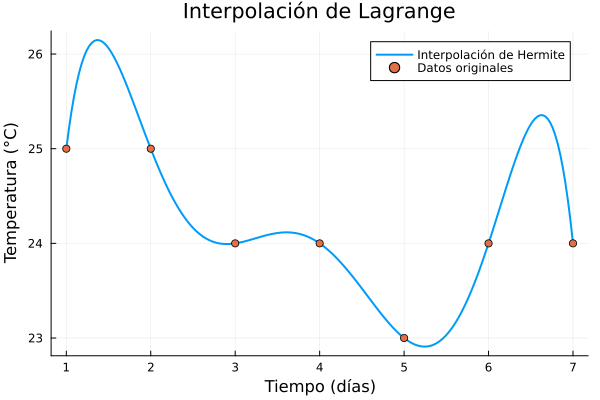

In [30]:
using SymPy
using Plots

function algoritmo(i, j, x)
    x_sim = symbols("x")
    if i != j
        return (x_sim - x[i]) / (x[j] - x[i])
    else
        return 1
    end
end

function interpol_lagrange(x, y; num_puntos=200)
    x_sim = symbols("x")
    points = length(x)
    lj = []
    for k in 1:points
        lk = prod([algoritmo(i, k, x) for i in 1:points])
        push!(lj, lk)
    end
    pol = sum(y.* lj)
    x_test = range(minimum(x), stop=maximum(x), length=num_puntos)
    y_pol = [pol(x_sim => i) for i in x_test]
    return x_test, y_pol
end

# Datos del problema
y = [25, 25, 24, 24, 23, 24, 24]
x = 1:length(y)

# Puntos generados por Lagrange
x_test, y_pol = interpol_lagrange(x, y)

# Mostrando gráfica

plot(x_test, y_pol, label="Interpolación de Hermite", linewidth=2)
scatter!(x, y, label="Datos originales", marker=:circle)
xlabel!("Tiempo (días)")
ylabel!("Temperatura (°C)")
title!("Interpolación de Lagrange")

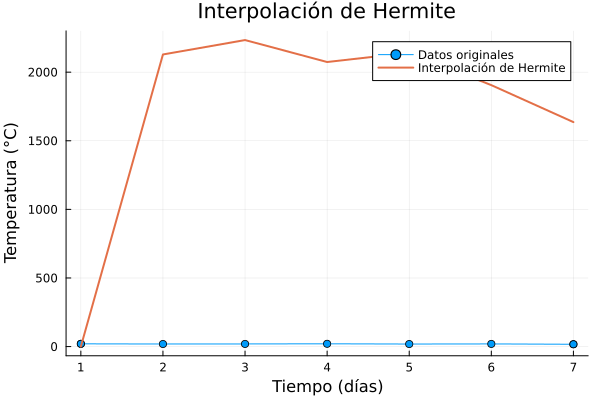

In [41]:
using Plots

tiempos = [1, 2, 3, 4, 5, 6, 7]
temperaturas = [20.15, 18.9, 19.4, 20.4, 18.7, 19.55, 17.1]

# Calculamos las derivadas aproximadas
dt = 0.1
derivadas = diff(temperaturas) ./ dt

#
# Calculamos las derivadas aproximadas
dt = 0.1
derivadas = diff(temperaturas)./dt

# Agregamos el primer y último punto para que la interpolación sea más precisa
tiempos = [tiempos[1]; tiempos; tiempos[end]]
temperaturas = [temperaturas[1]; temperaturas; temperaturas[end]]
derivadas = [derivadas[1]; derivadas; derivadas[end]]

# Definimos la función de interpolación de Hermite
function hermite_interpolation(tiempos, temperaturas, derivadas, x)
    idx = 1
    min_diff = abs(tiempos[1] - x)
    for i in 2:length(tiempos)
        diff = abs(tiempos[i] - x)
        if diff < min_diff
            min_diff = diff
            idx = i
        end
    end

    # Calcula los coeficientes de la interpolación de Hermite
    h00 = (tiempos[idx] - x)^2 * (tiempos[idx] - x - dt) / (dt^2)
    h10 = (tiempos[idx] - x)^2 / dt
    if idx > 1
        h01 = (x - tiempos[idx-1])^2 * (x - tiempos[idx-1] + dt) / (dt^2)
        h11 = (x - tiempos[idx-1])^2 / dt
        temp_interp = h00 * temperaturas[idx-1] + h10 * derivadas[idx-1] + h01 * temperaturas[idx] + h11 * derivadas[idx]
    else
        h01 = 0
        h11 = 0
        temp_interp = h00 * temperaturas[idx] + h10 * derivadas[idx]
    end

    return temp_interp
end

# Generamos los puntos de interpolación
x_interp = [1, 2, 3, 4, 5, 6, 7]

# Interpolamos la temperatura en los puntos de interpolación
temp_interp = [hermite_interpolation(tiempos, temperaturas, derivadas, x) for x in x_interp]

# Graficamos los datos originales y la interpolación de Hermite
plot(tiempos, temperaturas, label="Datos originales", marker=:circle)


xlabel!("Tiempo (días)")
ylabel!("Temperatura (°C)")
title!("Interpolación de Hermite")

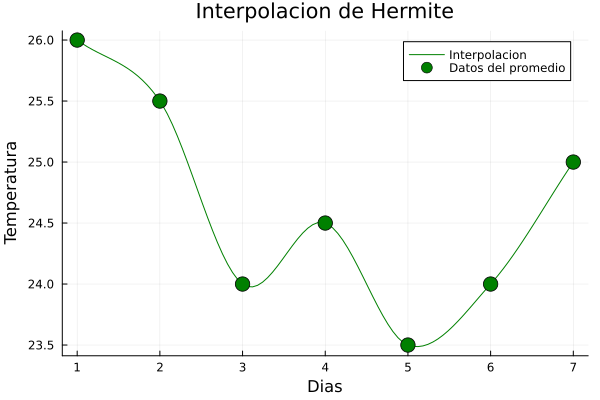

In [3]:
using PyCall
using Plots

np = pyimport("numpy")

function derivadas(x, y)
    n = length(x)
    dy = np.zeros(n)

    dy[1] = (y[2] - y[1]) / (x[2] - x[1])
    
    dy[end] = (y[end] - y[end-1]) / (x[end] - x[end-1])
    
    for i in 2:n-1
        dy[i] = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1])
    end
    
    return dy
end

function encontrar_indices(x_interp, x_i, x_sig)
    indices = []
    for (i, val) in enumerate(x_interp)
        if x_i <= val <= x_sig
            push!(indices, i)
        end
    end
    return indices
end

function interpolacion_hermite(x, y, dy, x_interp)
    n = length(x)
    y_interp = np.zeros_like(x_interp)
    
    for i in 1:n-1
        h = x[i + 1] - x[i]
        
        t = (x_interp .- x[i]) / h
        
        h00 = 2 .* t.^3 .- 3 .* t.^2 .+ 1
        h10 = t.^3 .- 2 .* t.^2 .+ t
        h01 = -2 .* t.^3 .+ 3 .* t.^2
        h11 = t.^3 .- t.^2
    
        idx = encontrar_indices(x_interp, x[i], x[i + 1])
        
        for j in idx
            y_interp[j] = h00[j] * y[i] + h10[j] * h * dy[i] + h01[j] * y[i + 1] + h11[j] * h * dy[i + 1]
        end

    end
    return y_interp
end

# Lista de temperaturas
t_hot= max_temps
t_cold= min_temps

promedio = np.zeros(length(t_hot))

for i in 1:length(t_hot)
    promedio[i]= (t_hot[i]+t_cold[i])/2
end

# Generar puntos correspondientes
x = np.arange(1,length(promedio)+1)
y = np.array(promedio)

# Convertit x es un vector de tipo Float64 sí no lo es ya
x = convert(Vector{Float64}, x)

# Calcular derivadas
dy = derivadas(x, y)

# Puntos más finos para evaluación (las lineas)
x_fine = np.linspace(x[1], x[end], 100)
y_fine = interpolacion_hermite(x, y, dy, x_fine)


plot(x_fine, y_fine, label="Interpolacion",color=:green)
scatter!(x, y, label="Datos del promedio", color=:green, marker=:circle, markersize=8)
plot!(title = "Interpolacion de Hermite", xlabel = "Dias", ylabel = "Temperatura")
